# Accelerating Deep Learning with Multiprocess Image Augmentation in Keras

* Benchmark of CIFAR10 (in memory)
    * Single process
    * Multiprocess with n_process = 1 to num_cores
    * Plot chart of duration
    * GPU / CPU utilization charts
* Benchmark of Kaggle Cat vs. Dog (stream from disk)
    * Single process
    * Multiprocess with n_process = 1 to num_cores
    * Plot chart of duration
    * GPU / CPU utilization charts
* Graceful interrupt of processes
    * should be able to start training again without terminating pool


In [1]:
import numpy as np
import keras as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
%%time
from keras.datasets.cifar10 import load_data
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = load_data()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

CPU times: user 104 ms, sys: 64 ms, total: 168 ms
Wall time: 167 ms


In [3]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img -= 0.5
    return img * 2

In [4]:
import time
import collections
#from keras.preprocessing.image import ImageDataGenerator

import tools.image as T

# Useful for checking the output of the generators after code change
#from importlib import reload
reload(T)

<module 'tools.image' from 'tools/image.pyc'>

In [5]:
import multiprocessing

In [ ]:
#         gen = T.ImageDataGenerator(
#              featurewise_center=False,
#              samplewise_center=False,
#              featurewise_std_normalization=False,
#              samplewise_std_normalization=False,
#              zca_whitening=False,
#              rotation_range=45,
#              width_shift_range=.1,
#              height_shift_range=.1,
#              shear_range=0.,
#              zoom_range=0,
#              channel_shift_range=0,
#              fill_mode='nearest',
#              cval=0.,
#              horizontal_flip=True,
#              vertical_flip=False,
#              rescale=None,
#              preprocessing_function=preprocess_img,
#              dim_ordering='default',
#              pool=pool
#         )

#         gen.fit(X_train)
#         X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

#         # fig, ax = plt.subplots(6, 6, figsize=(15, 15))
#         # for (imgs, labels) in X_train_aug:
#         #     for i in range(6):
#         #         for j in range(6):
#         #             if i*6 + j < 32:
#         #                 ax[i][j].imshow(imgs[i*6 + j])
#         #     break

In [59]:
durs = collections.defaultdict(list)
num_cores = 2
try:
    num_cores = multiprocessing.cpu_count()
except:
    pass

for j in range(1):
    print('Round', j)
    
    for num_p in range(0, num_cores + 1):
        pool = None
        if num_p > 0:
            pool = Pool(processes=num_p)
            
        start = time.time()
        gen = T.ImageDataGenerator(
             featurewise_center=False,
             samplewise_center=False,
             featurewise_std_normalization=False,
             samplewise_std_normalization=False,
             zca_whitening=False,
             rotation_range=45,
             width_shift_range=.1,
             height_shift_range=.1,
             shear_range=0.,
             zoom_range=0,
             channel_shift_range=0,
             fill_mode='nearest',
             cval=0.,
             horizontal_flip=True,
             vertical_flip=False,
             rescale=None,
             preprocessing_function=preprocess_img,
             dim_ordering='default',
             pool=pool
        )

        gen.fit(X_train)
        X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

        for i, (imgs, labels) in enumerate(X_train_aug):
            if i == 1000:
                break

        dur = time.time() - start
        print(num_p, dur)
        
        durs[num_p].append(dur)

        if pool:
            pool.terminate()

('Round', 0)
(0, 6.809176206588745)
(1, 11.278344869613647)
(2, 5.8856940269470215)
(3, 5.307810068130493)
(4, 4.535736083984375)
(5, 4.139847993850708)
(6, 3.5280981063842773)
(7, 3.207911968231201)
(8, 3.5982789993286133)
(9, 3.730372190475464)
(10, 3.6452879905700684)
(11, 3.6611030101776123)


In [64]:
durs[0][0] / durs[7][0]

2.1226194091427115

In [46]:
np.mean(np.array(durs.values()), axis=1)

array([ 21.41796374,  13.13238809,  10.11474316,   8.35957749,
         7.55707221,   6.94941163,   6.53304081,   7.4931978 ,
         7.3005033 ,   7.26154811,   7.22063091])

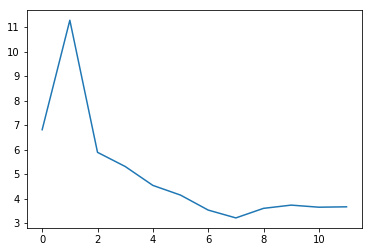

In [65]:
plt.plot(np.mean(np.array(durs.values()), axis=1))

In [52]:
pool = multiprocessing.Pool(processes=7)
#pool = None

gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=0,
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=None,
     preprocessing_function=preprocess_img,
     dim_ordering='default',
     pool=pool
)
test_gen = T.ImageDataGenerator(
    preprocessing_function=preprocess_img,
    pool=pool
)

gen.fit(X_train)
test_gen.fit(X_train)
X_train_aug = gen.flow(X_train, y_train_cat, seed=0, batch_size=32)
X_test_aug = test_gen.flow(X_test, y_test_cat, seed=0, batch_size=32)

In [54]:
pool = multiprocessing.Pool(processes=7)
#pool = None

gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=[.8, 1],
     channel_shift_range=20,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=None,
     preprocessing_function=preprocess_img,
     dim_ordering='default',
     pool=pool
)
test_gen = T.ImageDataGenerator(
    preprocessing_function=preprocess_img,
    pool=pool
)

gen.fit(X_train)
test_gen.fit(X_train)
X_train_aug = gen.flow(X_train, y_train_cat, seed=0, batch_size=32)
X_test_aug = test_gen.flow(X_test, y_test_cat, seed=0, batch_size=32)

In [9]:
for i, (imgs, labels) in enumerate(X_train_aug):
    print(i)
    print(imgs.shape)
    print(labels.shape)
    break

AssertionError: 

In [58]:
pool.terminate()

In [55]:
%%time

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization

# # Create the model
# model = Sequential()
# model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
# model.add(Dropout(0.2))
# model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# # Compile model
# epochs = 25
# lrate = 0.01
# decay = lrate/epochs
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# print(model.summary())

model = Sequential([
    Conv2D(32, 3, 3, border_mode='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(16, 3, 3, border_mode='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, 3, border_mode='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, 3, border_mode='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(X_train_aug, samples_per_epoch=50000, nb_epoch=10, 
                    validation_data=X_test_aug, nb_val_samples=10000)

#model.fit(X_train, y_train_cat, batch_size=512, validation_data=(X_test, y_test_cat), nb_epoch=200)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_65 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_17[0][0]     
____________________________________________________________________________________________________
maxpooling2d_65 (MaxPooling2D)   (None, 16, 16, 32)    0           convolution2d_65[0][0]           
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 16, 16, 16)    4624        maxpooling2d_65[0][0]            
____________________________________________________________________________________________________
maxpooling2d_66 (MaxPooling2D)   (None, 8, 8, 16)      0           convolution2d_66[0][0]           
___________________________________________________________________________________________

extended, 7 multiprocessing processes
Epoch 5/5
50000/50000 [==============================] - 10s - loss: 1.1621 - acc: 0.5886 - val_loss: 1.2799 - val_acc: 0.5821
CPU times: user 1min 28s, sys: 8.6 s, total: 1min 37s
Wall time: 57.4 s

extended, 1 process
Epoch 5/5
50000/50000 [==============================] - 17s - loss: 1.1866 - acc: 0.5787 - val_loss: 1.1124 - val_acc: 0.6045
CPU times: user 2min 39s, sys: 8.96 s, total: 2min 48s
Wall time: 1min 31s

## Dog vs. Cat Benchmark

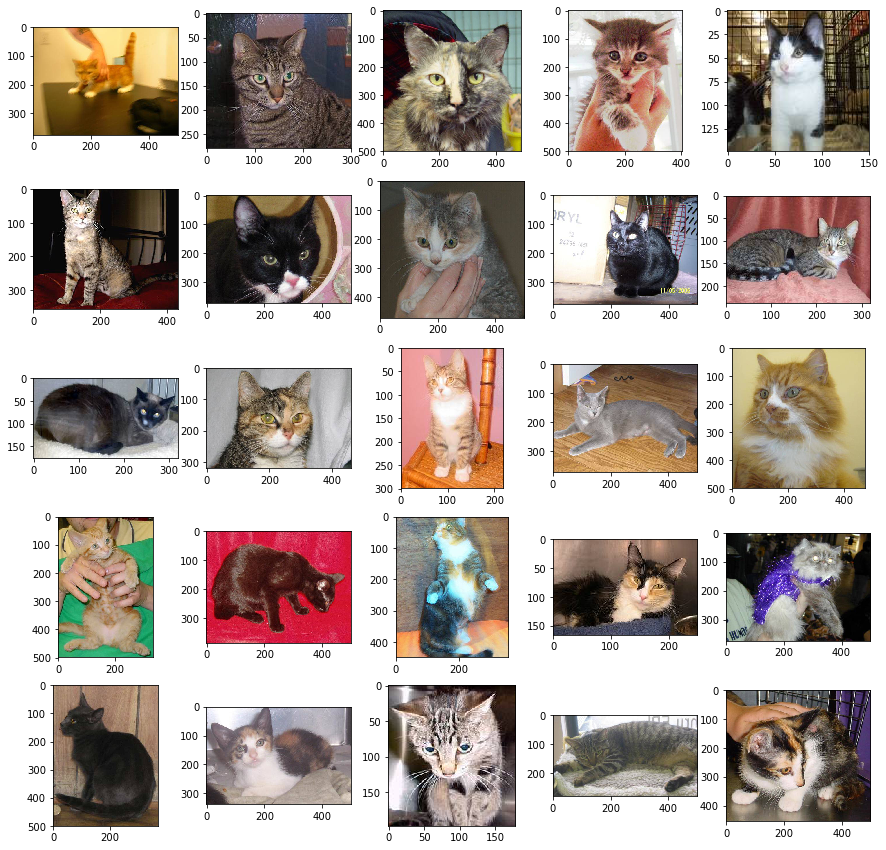

In [69]:
import os

paths = sorted(os.listdir('./data/train/cat'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/cat/' + paths[ix])
        ax[i][j].imshow(img)


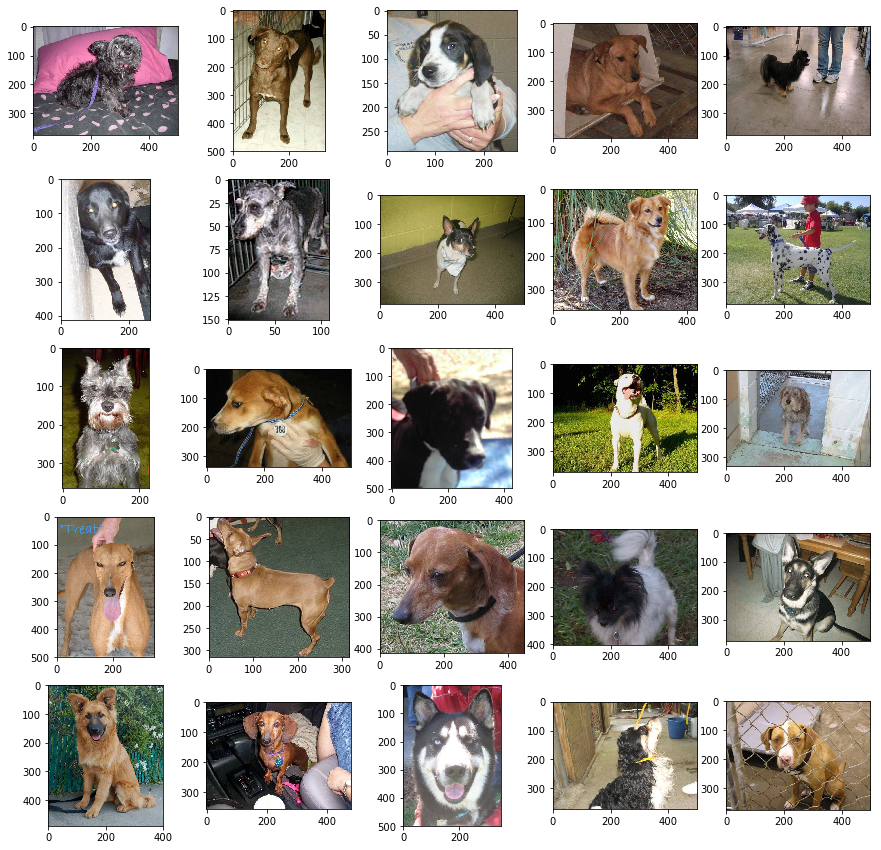

In [70]:
paths = sorted(os.listdir('./data/train/dog'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/dog/' + paths[ix])
        ax[i][j].imshow(img)


In [89]:
import keras.preprocessing.image as origImage


Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


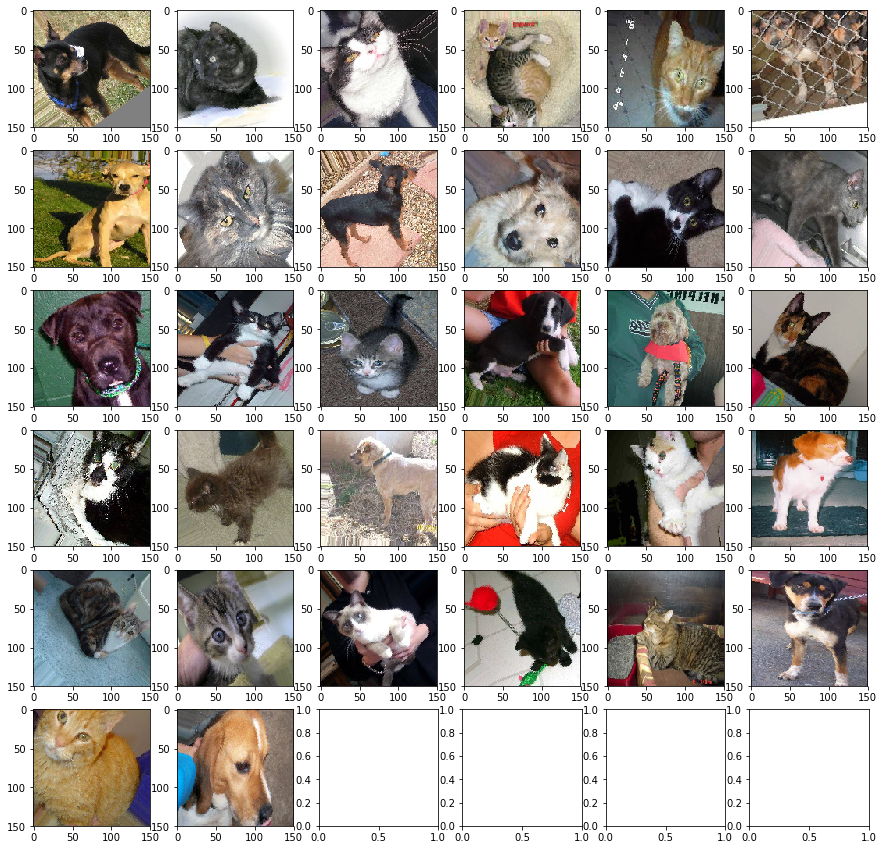

In [95]:
# gen = T.ImageDataGenerator(
gen = origImage.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=[.8, 1],
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
#      preprocessing_function=preprocess_img,
     #dim_ordering='default',
#      pool=None
)
test_gen = origImage.ImageDataGenerator(
    preprocessing_function=preprocess_img,
#     pool=None
)


train_generator = gen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = gen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# fig, ax = plt.subplots(6, 6, figsize=(15, 15))
# for (imgs, labels) in train_generator:
#     for i in range(6):
#         for j in range(6):
#             if i*6 + j < 32:
#                 ax[i][j].imshow(imgs[i*6 + j])
#     break


In [100]:
pool = multiprocessing.Pool(processes=7)

In [103]:

gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=[.8, 1],
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
#      preprocessing_function=preprocess_img,
     #dim_ordering='default',
     pool=pool
)
test_gen = T.ImageDataGenerator(
    preprocessing_function=preprocess_img,
    pool=pool
)


train_generator = gen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = gen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [104]:
%%time
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        samples_per_epoch=22778,
        nb_epoch=1,
        validation_data=test_generator,
        nb_val_samples=2222)

Epoch 1/1
22778/22778 [==============================] - 114s - loss: 0.6279 - acc: 0.6435 - val_loss: 0.5428 - val_acc: 0.7309
CPU times: user 2min 17s, sys: 3.74 s, total: 2min 20s
Wall time: 1min 54s


In [ ]:
Epoch 1/5
22778/22778 [==============================] - 116s - loss: 0.6286 - acc: 0.6419 - val_loss: 0.5760 - val_acc: 0.6967